In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

In [15]:
df = pd.read_csv('new_file.csv')
df.head()

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo_cantar,trend,likes,views,comments,saved,compartidos,encoded_color,encoded_light
0,1,0,0,0,1,1,67100,281500,225,8412,2042,0,0
1,1,1,0,0,1,0,7372,58400,66,729,52,1,1
2,0,1,0,0,0,0,5927,46000,67,725,242,0,0
3,1,1,1,0,1,0,110000,746100,614,18500,2509,0,0
4,1,0,0,0,0,1,6812,921000,651,836,54,0,2


In [16]:
df1 = df.drop(['sub_mono','cover','sub_doble','sub_doble_intermitente','directo_cantar', 'trend','encoded_color','encoded_light'], axis='columns')

In [17]:
df2 = df.drop( ['views','likes','comments','saved','compartidos'], axis='columns')

In [18]:
def plot_hist(df, columns_array):
    for column_name in columns_array:
        df[column_name].plot(kind='hist', bins=10, color='skyblue', edgecolor='black')
        plt.title('Histogram of ' + column_name)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()

In [19]:
from sklearn.neighbors import KernelDensity

def generate_samples_with_kde(df, num_estimated_samples):
    new_data = {}
    
    for column in df.columns:
        # Fit KDE to the data in each column
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(df[[column]])
        
        new_samples = kde.sample(num_estimated_samples)
        
        new_samples = np.ravel(new_samples)
        
        new_data[column] = new_samples
    
    KDE_df = pd.DataFrame(new_data)
    
    # Concatenate the new DataFrame with the original DataFrame along the rows (axis 0)
    augmented_df = pd.concat([df, KDE_df], axis=0, ignore_index=True)
    
    return augmented_df

def augment_with_kde_iteratively(df, num_iterations, num_estimated_samples):
    augmented_df = df
    
    for i in range(num_iterations):
        augmented_df = generate_samples_with_kde(augmented_df, num_estimated_samples)
    
    return augmented_df

In [55]:
def bootstrap_samples(df, num_samples):
    """
    Generate bootstrap samples by resampling the rows of the DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data.
    - num_samples: Number of bootstrap samples to generate.

    Returns:
    - augmented_df: Augmented DataFrame containing the original data plus the bootstrap samples.
    """
    # Get the number of rows in the original DataFrame
    num_rows = len(df)
    
    # Initialize an empty DataFrame to store the augmented data
    augmented_df = pd.DataFrame()

    # Generate bootstrap samples
    for _ in range(num_samples):
        # Randomly sample rows with replacement
        bootstrap_rows = np.random.choice(num_rows, size=num_rows, replace=True)
        
        # Select the sampled rows from the original DataFrame
        bootstrap_sample = df.iloc[bootstrap_rows]
        
        # Concatenate the bootstrap sample with the augmented DataFrame
        augmented_df = pd.concat([augmented_df, bootstrap_sample], ignore_index=True)
    
    return augmented_df

def augment_bootstrap_iteratively(df,num_samples, num_iterations):
    augmented_df =df
    for i in range(num_iterations):
        augmented_df = bootstrap_samples(df, num_samples)
    return augmented_df

In [70]:
non_binary_df= augment_with_kde_iteratively(df1, num_iterations=319, num_estimated_samples=9)
non_binary_df

,likes,views,comments,saved,compartidos
0,67100.000000,2.815000e+05,225.000000,8412.000000,2042.000000
1,7372.000000,5.840000e+04,66.000000,729.000000,52.000000
2,5927.000000,4.600000e+04,67.000000,725.000000,242.000000
3,110000.000000,7.461000e+05,614.000000,18500.000000,2509.000000
4,6812.000000,9.210000e+05,651.000000,836.000000,54.000000
...,...,...,...,...,...
2895,31604.539189,6.790352e+04,189.733887,220.428040,337.064970
2896,6813.074019,7.183009e+05,115.918186,730.260171,5517.195670
2897,31605.013650,7.182990e+05,1463.739876,6135.449393,2505.860047
2898,2911.123550,1.400002e+06,188.452053,303.521465,-3.353865


In [71]:
binary_df = augment_bootstrap_iteratively(df2,100,100)
binary_df 

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo_cantar,trend,encoded_color,encoded_light
0,1,1,0,0,1,1,0,0
1,1,0,0,0,0,0,0,2
2,0,1,1,0,0,0,0,2
3,0,0,1,0,0,0,0,2
4,1,1,1,0,0,1,0,2
...,...,...,...,...,...,...,...,...
2895,0,1,1,0,0,1,0,2
2896,1,0,0,1,1,0,0,2
2897,1,1,0,0,0,0,0,2
2898,0,0,1,1,0,0,0,2


In [73]:
merged_df = pd.merge(binary_df, non_binary_df, left_index=True, right_index=True)

In [75]:
merged_df

,sub_mono,cover,sub_doble,sub_doble_intermitente,directo_cantar,trend,encoded_color,encoded_light,likes,views,comments,saved,compartidos
0,1,1,0,0,1,1,0,0,67100.000000,2.815000e+05,225.000000,8412.000000,2042.000000
1,1,0,0,0,0,0,0,2,7372.000000,5.840000e+04,66.000000,729.000000,52.000000
2,0,1,1,0,0,0,0,2,5927.000000,4.600000e+04,67.000000,725.000000,242.000000
3,0,0,1,0,0,0,0,2,110000.000000,7.461000e+05,614.000000,18500.000000,2509.000000
4,1,1,1,0,0,1,0,2,6812.000000,9.210000e+05,651.000000,836.000000,54.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0,1,1,0,0,1,0,2,31604.539189,6.790352e+04,189.733887,220.428040,337.064970
2896,1,0,0,1,1,0,0,2,6813.074019,7.183009e+05,115.918186,730.260171,5517.195670
2897,1,1,0,0,0,0,0,2,31605.013650,7.182990e+05,1463.739876,6135.449393,2505.860047
2898,0,0,1,1,0,0,0,2,2911.123550,1.400002e+06,188.452053,303.521465,-3.353865


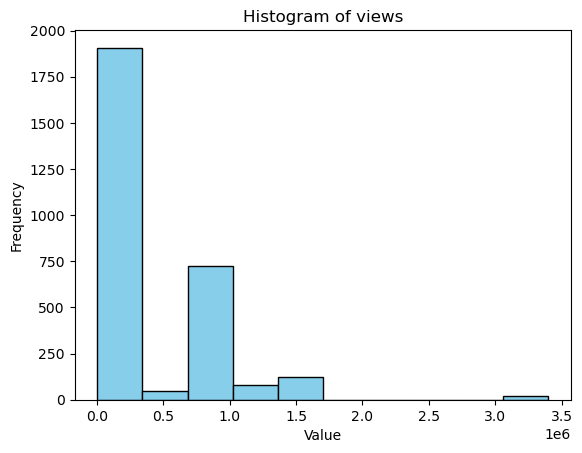

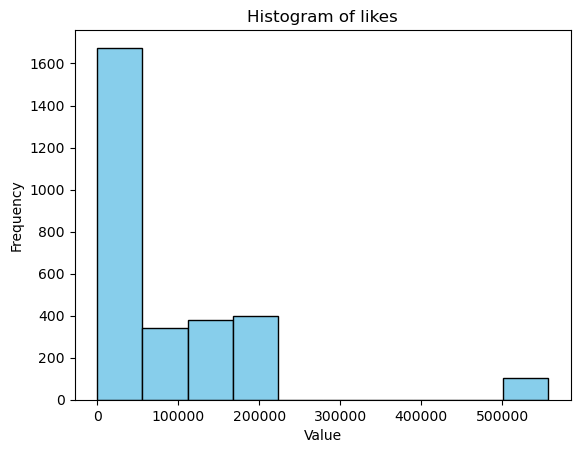

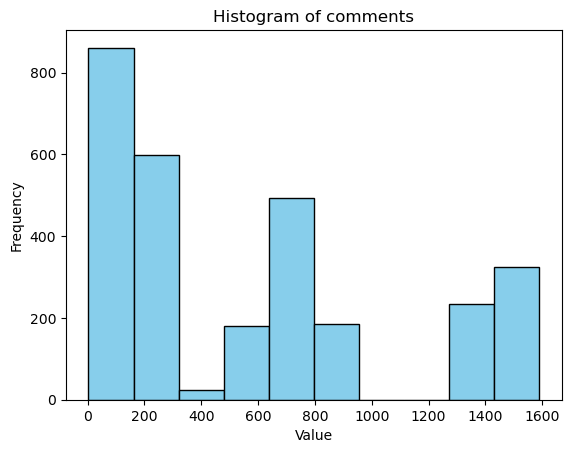

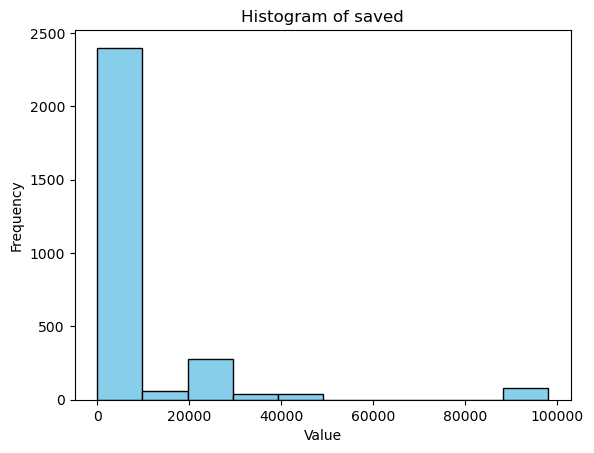

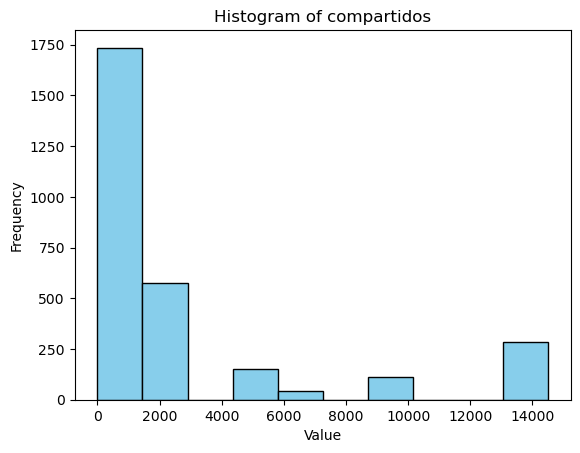

In [25]:
plot_hist(non_binary_df, ['views','likes','comments','saved','compartidos'])

In [76]:
file_path = r"C:\Users\perez\Documents\MachineLearning\Tiktok\new_df_p_augmentation.csv"

# Save the DataFrame to a CSV file
merged_df.to_csv(file_path, index=False) 

In [ ]:
plot_std_counts(new_df['sub_doble'], new_df['compartidos'], title='Count of shares against doble sub ', xlabel='Categories', ylabel='number of doble subs')
plot_std_counts(new_df['sub_mono'], new_df['compartidos'], title='Count of shares against monotunus subtitles', xlabel='Categories', ylabel='number of monotunus subtitles')
plot_std_counts(new_df['cover'], new_df['compartidos'], title='Count of shares against videos with cover', xlabel='Categories', ylabel='number of covers')
plot_std_counts(new_df['trend'], new_df['compartidos'], title='Count of shares against videos with trend', xlabel='Categories', ylabel='number of trends')
plot_std_counts(new_df['directo_cantar'], new_df['compartidos'], title='Count of shares against videos stright foward singing', xlabel='Categories', ylabel='number of trends')